In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import shap

In [24]:
# Load and preprocess the dataset
df = pd.read_csv('../data/pd_collisions_datasd.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: x >= 5)
df['rush_hour'] = df['hour'].apply(lambda x: 7 <= x <= 9 or 16 <= x <= 18)
df['severity'] = df['injured'] + 3 * df['killed']
df['severity_label'] = pd.cut(df['severity'], bins=[-1, 0, 2, 100], labels=[0, 1, 2])
df['severity_label'] = df['severity_label'].astype(float).fillna(2).astype(int)
df['severity_label'] = df['severity_label'].astype(str)
df['severity_label'] = LabelEncoder().fit_transform(df['severity_label'])

In [25]:

# Feature Engineering: Clustered 'police_beat'
class PoliceBeatClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10):
        self.n_clusters = n_clusters
        self.kmeans = None
        self.label_enc = LabelEncoder()
    
    def fit(self, X, y=None):
        encoded = self.label_enc.fit_transform(X['police_beat'].astype(str)).reshape(-1,1)
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(encoded)
        return self
    
    def transform(self, X):
        encoded = self.label_enc.fit_transform(X['police_beat'].astype(str)).reshape(-1,1)
        X = X.copy()
        X['police_beat_cluster'] = self.kmeans.predict(encoded)
        return X.drop(columns=['police_beat'])
    
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'rush_hour',
            'police_beat_cluster', 'violation_type', 'hit_run_lvl']
target = 'severity_label'


In [26]:
# Apply clustering transformation
df_model = PoliceBeatClusterer().fit_transform(df)
df_model = df_model[features + [target]].dropna()

print("Unique severity labels:", df_model[target].unique())

# Encode remaining categorical features
cat_cols = ['violation_type', 'hit_run_lvl']
for col in cat_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

df_model['is_weekend'] = df_model['is_weekend'].astype(int)
df_model['rush_hour'] = df_model['rush_hour'].astype(int)

X = df_model.drop(columns=target)
y = df_model[target]

Unique severity labels: [0 2 1]


In [27]:
# SMOTEEN Resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Base Models
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgb = LGBMClassifier(random_state=42)
logreg = LogisticRegression(max_iter=1000)

In [28]:
# Calibration
rf_cal = CalibratedClassifierCV(rf, method='isotonic', cv=3)
xgb_cal = CalibratedClassifierCV(xgb, method='isotonic', cv=3)
lgb_cal = CalibratedClassifierCV(lgb, method='isotonic', cv=3)

# Voting Ensemble
voting_ensemble = VotingClassifier(estimators=[
    ('rf', rf_cal),
    ('xgb', xgb_cal),
    ('lgb', lgb_cal)
], voting='soft')

# Stacking Ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('rf', rf_cal), ('xgb', xgb_cal), ('lgb', lgb_cal)],
    final_estimator=logreg
)

In [29]:
# Evaluate Models
models = {
    'Random Forest': rf_cal,
    'XGBoost': xgb_cal,
    'LightGBM': lgb_cal,
    'Voting Ensemble': voting_ensemble,
    'Stacking Ensemble': stacking_ensemble
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}: ")
    print(classification_report(y_test, y_pred))

Classification Report for Random Forest: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5235
           1       0.18      0.23      0.20       814
           2       0.03      0.12      0.05        41

    accuracy                           0.74      6090
   macro avg       0.36      0.39      0.37      6090
weighted avg       0.78      0.74      0.76      6090



[23:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Classification Report for XGBoost: 
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      5235
           1       0.16      0.28      0.20       814
           2       0.04      0.22      0.07        41

    accuracy                           0.68      6090
   macro avg       0.36      0.41      0.36      6090
weighted avg       0.78      0.68      0.72      6090

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 24490, number of used features: 7
[LightGBM] [Info] Start training from score -1.140175
[LightGBM] [Info] Start training from score -1.372909
[LightGBM] [Info] Start training from score -0.851280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

[23:25:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 24490, number of used features: 7
[LightGBM] [Info] Start training from score -1.140175
[LightGBM] [Info] Start training from score -1.372909
[LightGBM] [Info] Start training from score -0.851280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 24491, number of used features: 7
[LightGBM] [Info] Start training from score -1.140215
[LightGBM] [Info] Start training from score -1.372950
[LightGBM] [Info] Start traini

[23:25:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:25:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 24490, number of used features: 7
[LightGBM] [Info] Start training from score -1.140175
[LightGBM] [Info] Start training from score -1.372909
[LightGBM] [Info] Start training from score -0.851280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 24491, number of used features: 7
[LightGBM] [Info] Start training from score -1.140215
[LightGBM] [Info] Start training from score -1.372950
[LightGBM] [Info] Start traini

[23:26:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:26:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:26:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:26:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:26:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:27:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:27:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[23:27:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 19592, number of used features: 7
[LightGBM] [Info] Start training from score -1.140302
[LightGBM] [Info] Start training from score -1.372909
[LightGBM] [Info] Start training from score -0.851185
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 19592, number of used features: 7
[LightGBM] [Info] Start training from score -1.140143
[LightGBM] [Info] Start training from score -1.372909
[LightGBM] [Info] Start traini

ExactExplainer explainer: 101it [01:01,  1.33it/s]                         


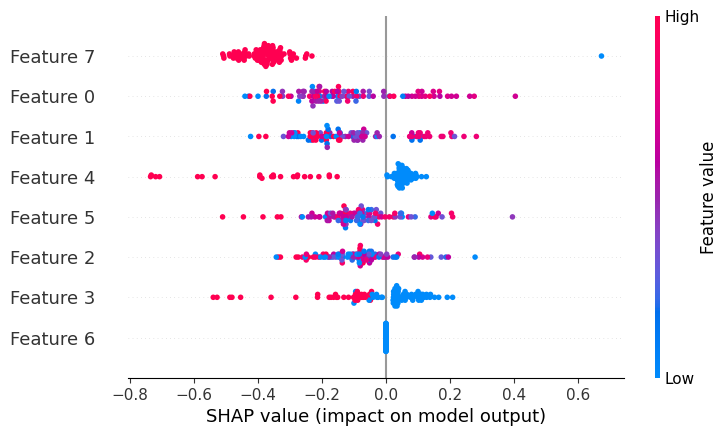

In [31]:
rf_cal.fit(X_train_res, y_train_res)
explainer = shap.Explainer(rf_cal.predict, X_train_res)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values, max_display=15)